# МФТИ-Coursera. Курс 5. Неделя 1. Контрольное задание

В файле записаны данные о средней заработной плате в России за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.



In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [ ]:
wage = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## 1. Визуальный анализ ряда

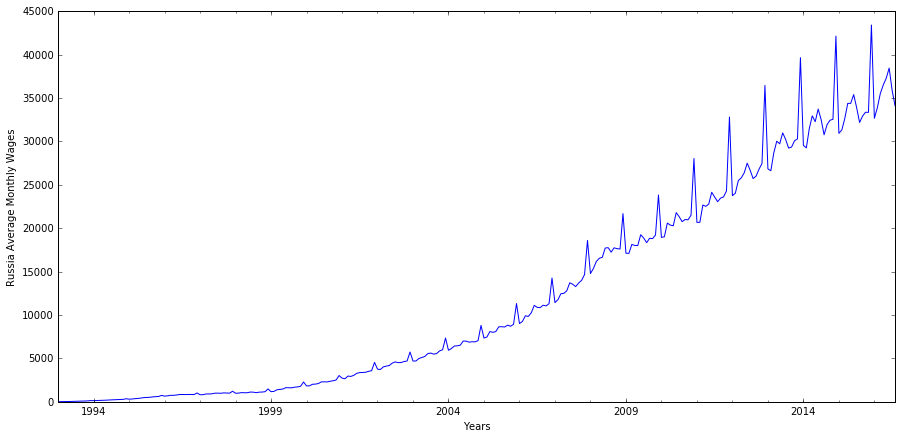

In [5]:
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel('Russia Average Monthly Wages')
plt.xlabel('Years')
pylab.show()

Что можем сказать про этот ряд по его графическому отображению? Cильно выражены годовая сезонность и тренд на повышение уровня зарплаты. Дисперсия нестационарная - размах сезонных колебаний в начале ряда гораздо меньше, чем ближе к концу.

**Проверка стационарности и STL-декомпозиция ряда:**

In [6]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1]

Критерий Дики-Фуллера: p=0.991850


Критерием Дики-Фуллера гипотеза нестационарности для данного ряда не отвергается.

Сделаем STL-декомпозицию. Посмотрим грфики, которые позволяют вам посмотреть, из каких примерно компонент состоит ряд.

STL-декомпозиция исходного ряда:


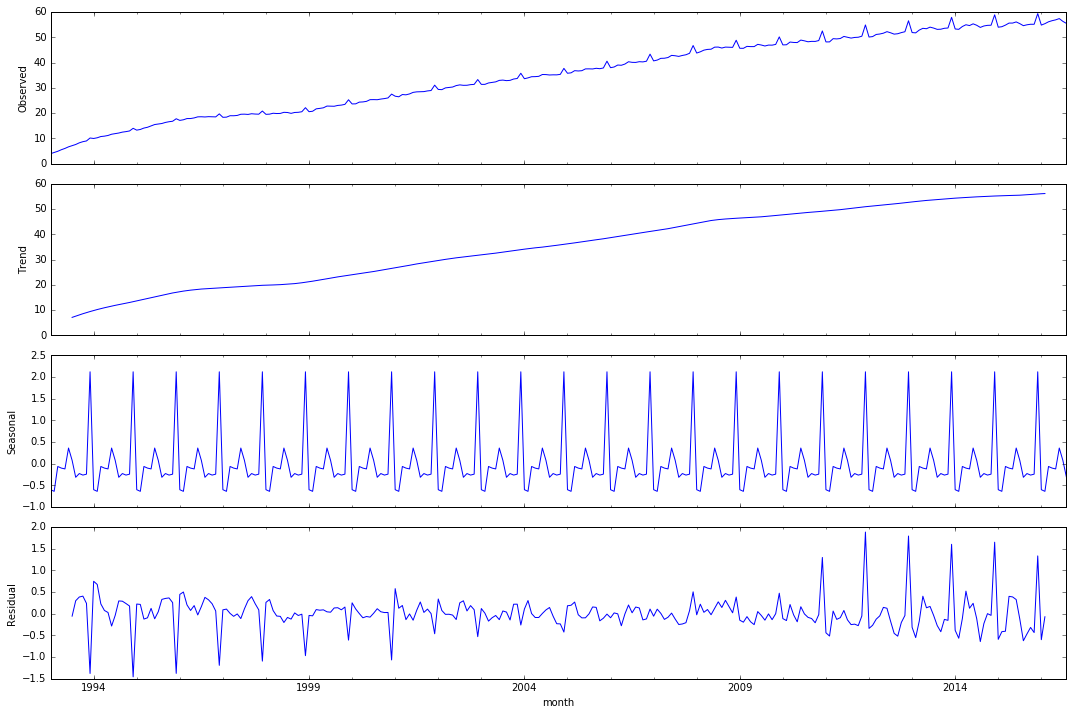

In [25]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print"STL-декомпозиция исходного ряда:"

На верхнем графике показан исходный ряд. На нижних трёх, соответственно, - тренд, сезонность и остатки. Остатки - всё, что не определяется суммой тренда и сезонности.

Видим, что сезонный профиль хорошо выражен.
Тренд почти монотонный.
То есть сомнений в нестационарности не возникает.
Вот шум подозрителен. Слишком хорошо структурирован. Похоже, с ним ещё можно работать.

## 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии с помощью функции "boxcox", которая возвращает преобразованный ряд и подобранное наилучшее значение параметра лямбда:

In [15]:
wage['wag_box'], lmbda = stats.boxcox(wage.WAG_C_M)
wage.head()

,WAG_C_M,wag_box
month,,
1993-01-01,3.990393,2.887091
1993-02-01,4.458758,3.328170
1993-03-01,4.931635,3.771541
1993-04-01,5.549430,4.348145
1993-05-01,6.063406,4.825801


In [10]:
print "Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wag_box)[1]

Оптимальный параметр преобразования Бокса-кокса: 0.958328
Критерий Дики-Фуллера: p=0.606146


Ожидаемо, критерий Дики-Фуллера не отвергает гипотезу нестационарности.

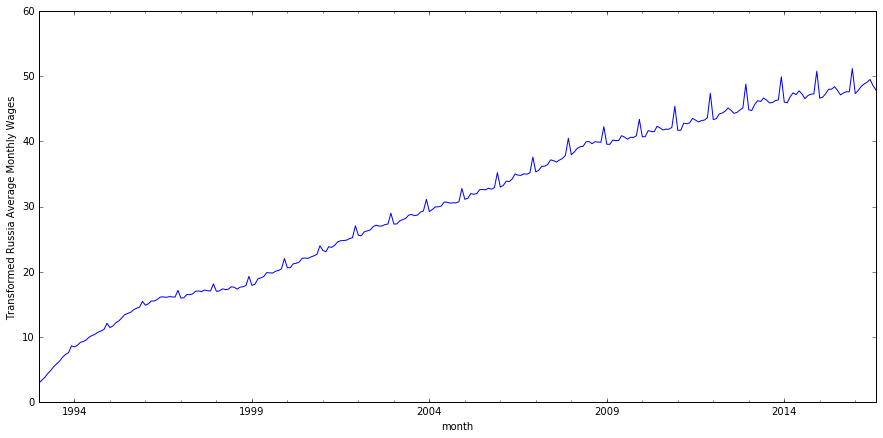

In [12]:
plt.figure(figsize(15,7))
wage.wag_box.plot()
plt.ylabel(u'Transformed Russia Average Monthly Wages')


Хорошо заментно, что стационарным этот ряд считать нельзя. Сохранился и тренд, и сезонность. 

Проведём дифференцирование ряда, чтобы добиться стационарности.

## 3. Выбор порядка дифференцирования

Попробуем сезонное дифференцирование. Затем сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность. Сдвиг в 12 месяцев.

In [18]:
wage['wag_box_diff'] = wage.wag_box - wage.wag_box.shift(12)
wage.head()

,WAG_C_M,wag_box,wag_box_diff
month,,,
1993-01-01,3.990393,2.887091,NaN
1993-02-01,4.458758,3.328170,NaN
1993-03-01,4.931635,3.771541,NaN
1993-04-01,5.549430,4.348145,NaN
1993-05-01,6.063406,4.825801,NaN


In [21]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wag_box_diff[12:])[1]

Критерий Дики-Фуллера: p=0.014746


STL-декомпозиция продифференцированного (12) ряда:


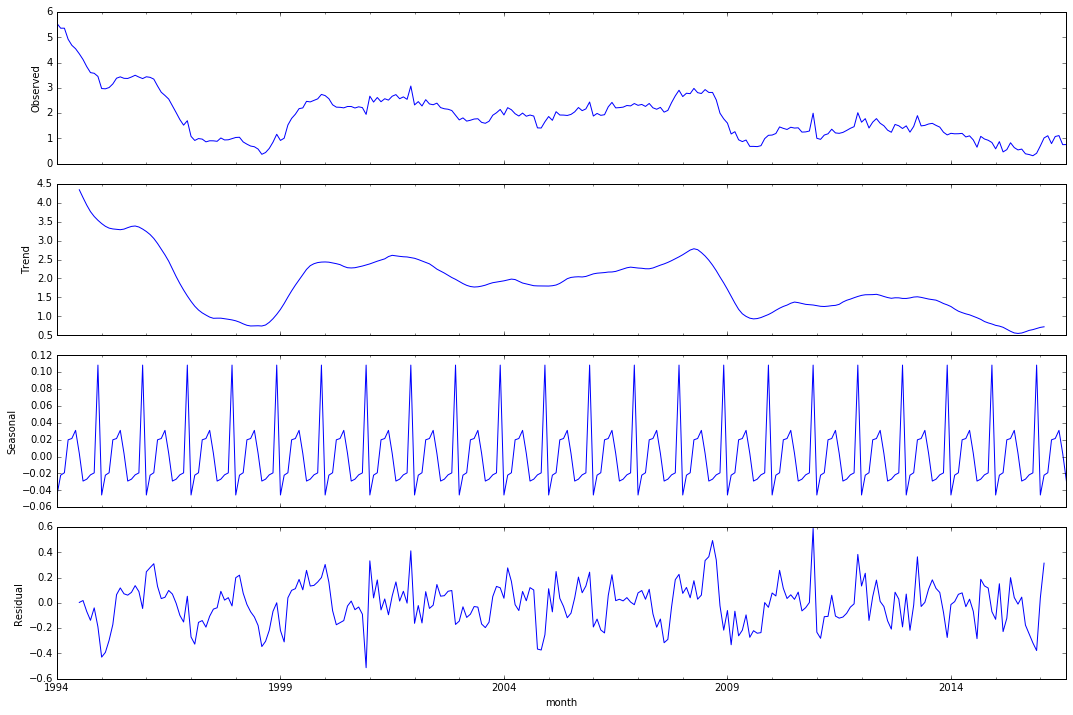

In [27]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wag_box_diff[12:]).plot()
print"STL-декомпозиция продифференцированного (12) ряда:"

Критерий Дики-Фуллера отвергает гипотезу нестационарности продифференцированного ряда, и тренд уже не очевиден. В ошибке структура тоже не видна. Но попробуем добавить ещё обычное дифференцирование - сдвиг на 1 период (месяц):

In [30]:
wage['wag_box_diff2'] = wage.wag_box_diff - wage.wag_box_diff.shift(1)
wage[12:20]

,WAG_C_M,wag_box,wag_box_diff,wag_box_diff2
month,,,,
1994-01-01,9.996196,8.433185,5.546093,NaN
1994-02-01,10.272455,8.684029,5.355859,-0.190235
1994-03-01,10.762540,9.128341,5.356800,0.000942
1994-04-01,10.916080,9.267366,4.919221,-0.437579
1994-05-01,11.180371,9.506481,4.680679,-0.238542
1994-06-01,11.672918,9.951485,4.544970,-0.135709
1994-07-01,11.931744,10.185012,4.344363,-0.200607
1994-08-01,12.148599,10.380508,4.119482,-0.224882


In [31]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wag_box_diff2[13:])[1]

Критерий Дики-Фуллера: p=0.000000


STL-декомпозиция дважды продифференцированного (12 + 1) ряда:


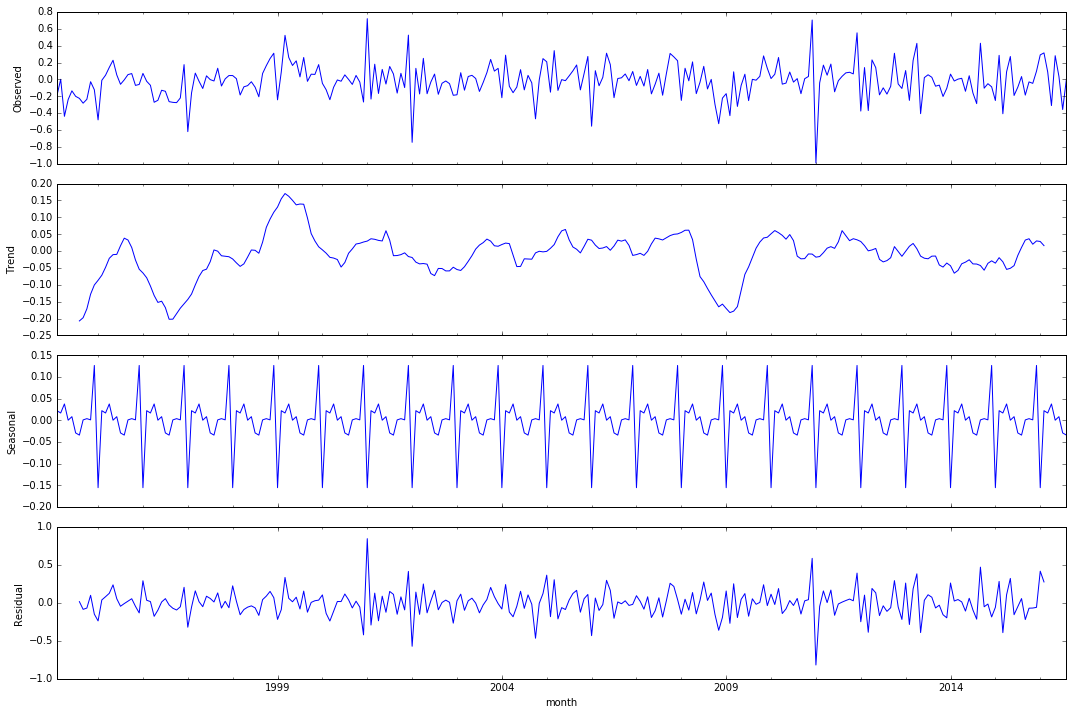

In [34]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wag_box_diff2[13:]).plot()
print"STL-декомпозиция дважды продифференцированного (12 + 1) ряда:"

Гипотеза нестационарности отвергается с ещё большей уверенностью и визуально ряд выглядит лучше — тренд не просматривается. 

Мы готовы перейти к подбору модели ARIMA, для чего создадим графики автокорреляции и частичной автокорреляции нашего дважды продиффиринцированного ряда.

## 4. Выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда:

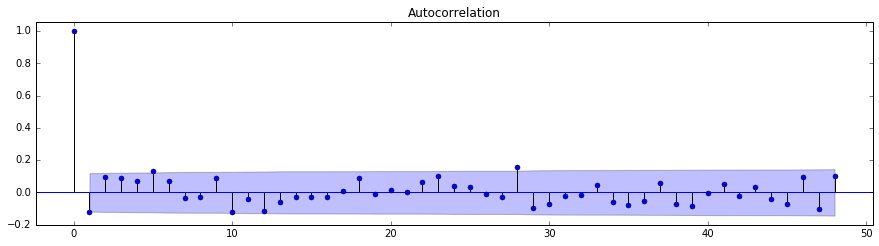

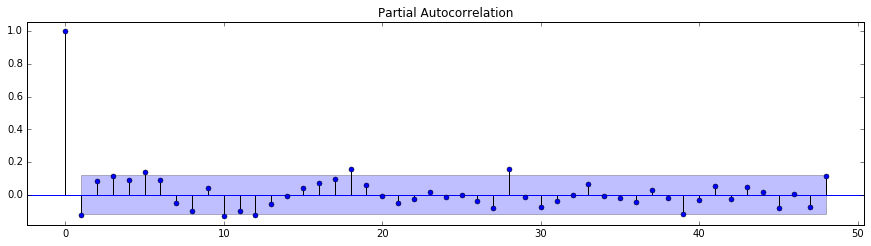

In [35]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=0, p=1

In [36]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [37]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [38]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore') # Отключаем предупреждения, так как не все модели можно хорошо настроить

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 12.8 s


In [39]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters        aic
29  (3, 1, 1, 0) -86.664973
28  (3, 1, 0, 1) -85.926139
30  (3, 1, 1, 1) -85.855829
37  (4, 1, 1, 0) -85.718571
36  (4, 1, 0, 1) -85.035430


Лучшая модель:

In [40]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  49.332
Date:                            Thu, 29 Sep 2016   AIC                            -86.665
Time:                                    00:20:28   BIC                            -64.771
Sample:                                01-01-1993   HQIC                           -77.887
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4985      0.193      2.585      0.010       0.121       0.876
ar.L2          0.1665      0.074   

## 6. Анализ остатков построенной модели

Из вышеприведённых результатов видим, что значение статистики Q-теста Льюнга—Бокса = 48.34 и p-value для него = 0.17. То есть гипотеза о случайности остатков не отвергается, и скорее всего полученный ряд представляет собой «белый шум».

Посмотрим на остатки:

Критерий Стьюдента: p=0.269640
Критерий Дики-Фуллера: p=0.000000


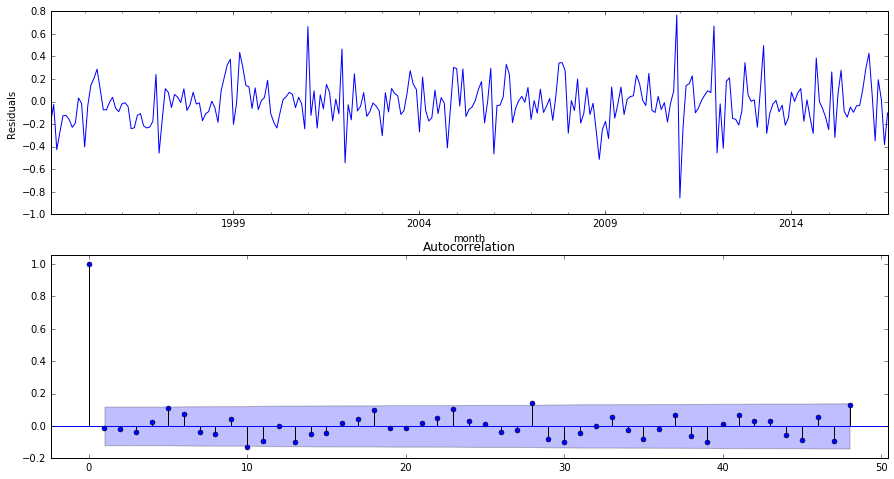

In [41]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

Видим, что модификация найденной модели не нужна, так как остатки получаются не смещёнными. Иначе прогноз пришлось бы скорректировать на константу. Остатки стационарны, не автокоррелированы. Если было бы иначе, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

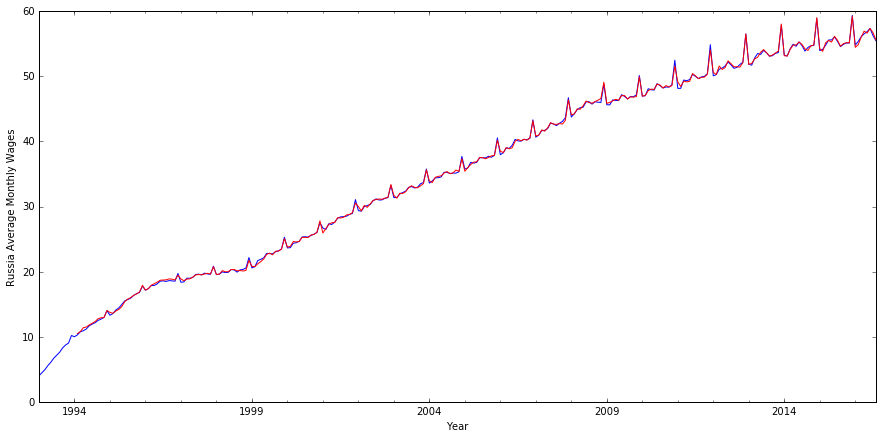

In [45]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Russia Average Monthly Wages')
plt.xlabel('Year')
pylab.show()

## 7. Прогнозирование с помощью финальной модели

In [42]:
wage2 = wage[['WAG_C_M']]
wage2.head()

,WAG_C_M
month,
1993-01-01,3.990393
1993-02-01,4.458758
1993-03-01,4.931635
1993-04-01,5.549430
1993-05-01,6.063406


In [47]:
wage2.shape

(284, 1)

Прогноз делаем на 2 года вперёд, начиная с сентября 2016, с помощью функции __predict__. C применением обратного преобразования к приобразованию Бокса-Кокоса, так как модель, которую мы подобрали, не знает о том, что исходный ряд был преобразован и всё в ней подбиралось на данных ряда, полученного уже после преобразования Бокса-Кокса.

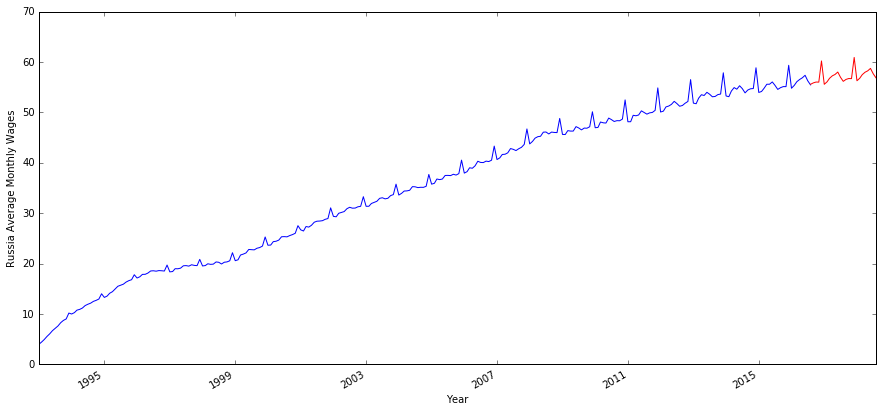

In [55]:
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=283, end=307), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Russia Average Monthly Wages')
plt.xlabel('Year')
pylab.show()